This notebook walks through an example of how to use the Aryn Partitioning Service with OpenAI's gpt-40-mini model to transform process flow diagrams (PFDs) into a DAG encoded in JSON.

We first use the Aryn SDK to pull out an image of the PFD from a page. We then send that diagram to OpenAI's gpt model and ask it to transform the contents of that flow into a DAG expressed as nodes and edges in a JSON.

You will need an Aryn API key and an Open AI API key to run this notebook. You can obtain an Aryn API key [here](https://www.aryn.ai/get-started ) and an OpenAI API key [here](https://platform.openai.com/api-keys).

In [70]:
#Install Aryn SDK
!pip install aryn-sdk

#Install Poppler utils so the PDF can be displayed
!apt-get install poppler-utils

#Install OpenAI SDK
!pip install openai

#Install pydantic
!pip install pydantic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [71]:
# Import necessary functions
import aryn_sdk
from aryn_sdk.partition import partition_file, draw_with_boxes, convert_image_element, table_elem_to_dataframe
import json
import pdf2image
from openai import OpenAI
from pydantic import BaseModel
from openai.lib._parsing import type_to_response_format_param as pydantic_to_response_format
from google.colab import userdata

In [72]:
# Set your secrets in the colab notebook. Navigate to the left pane
# and choose the key option to set your keys. Make sure to enable Notebook access

# Visit https://www.aryn.ai/get-started to get a key.
aryn_api_key = userdata.get('aryn_api_key')

# Visit https://platform.openai.com/api-keys to get a key.
openai_api_key = userdata.get('openai_api_key')

In [73]:
# get files from Aryn's public S3 bucket.
#![ -f PFD2.pdf ] || wget https://aryn-public.s3.amazonaws.com/partitioner-blog-data/PFD2.pdf
#![ -f PFD_2017.pdf ] || wget https://aryn-public.s3.amazonaws.com/partitioner-blog-data/PFD_2017.pdf
#![ -f PFD_2018.pdf ] || wget https://aryn-public.s3.amazonaws.com/partitioner-blog-data/PFD_2018.pdf

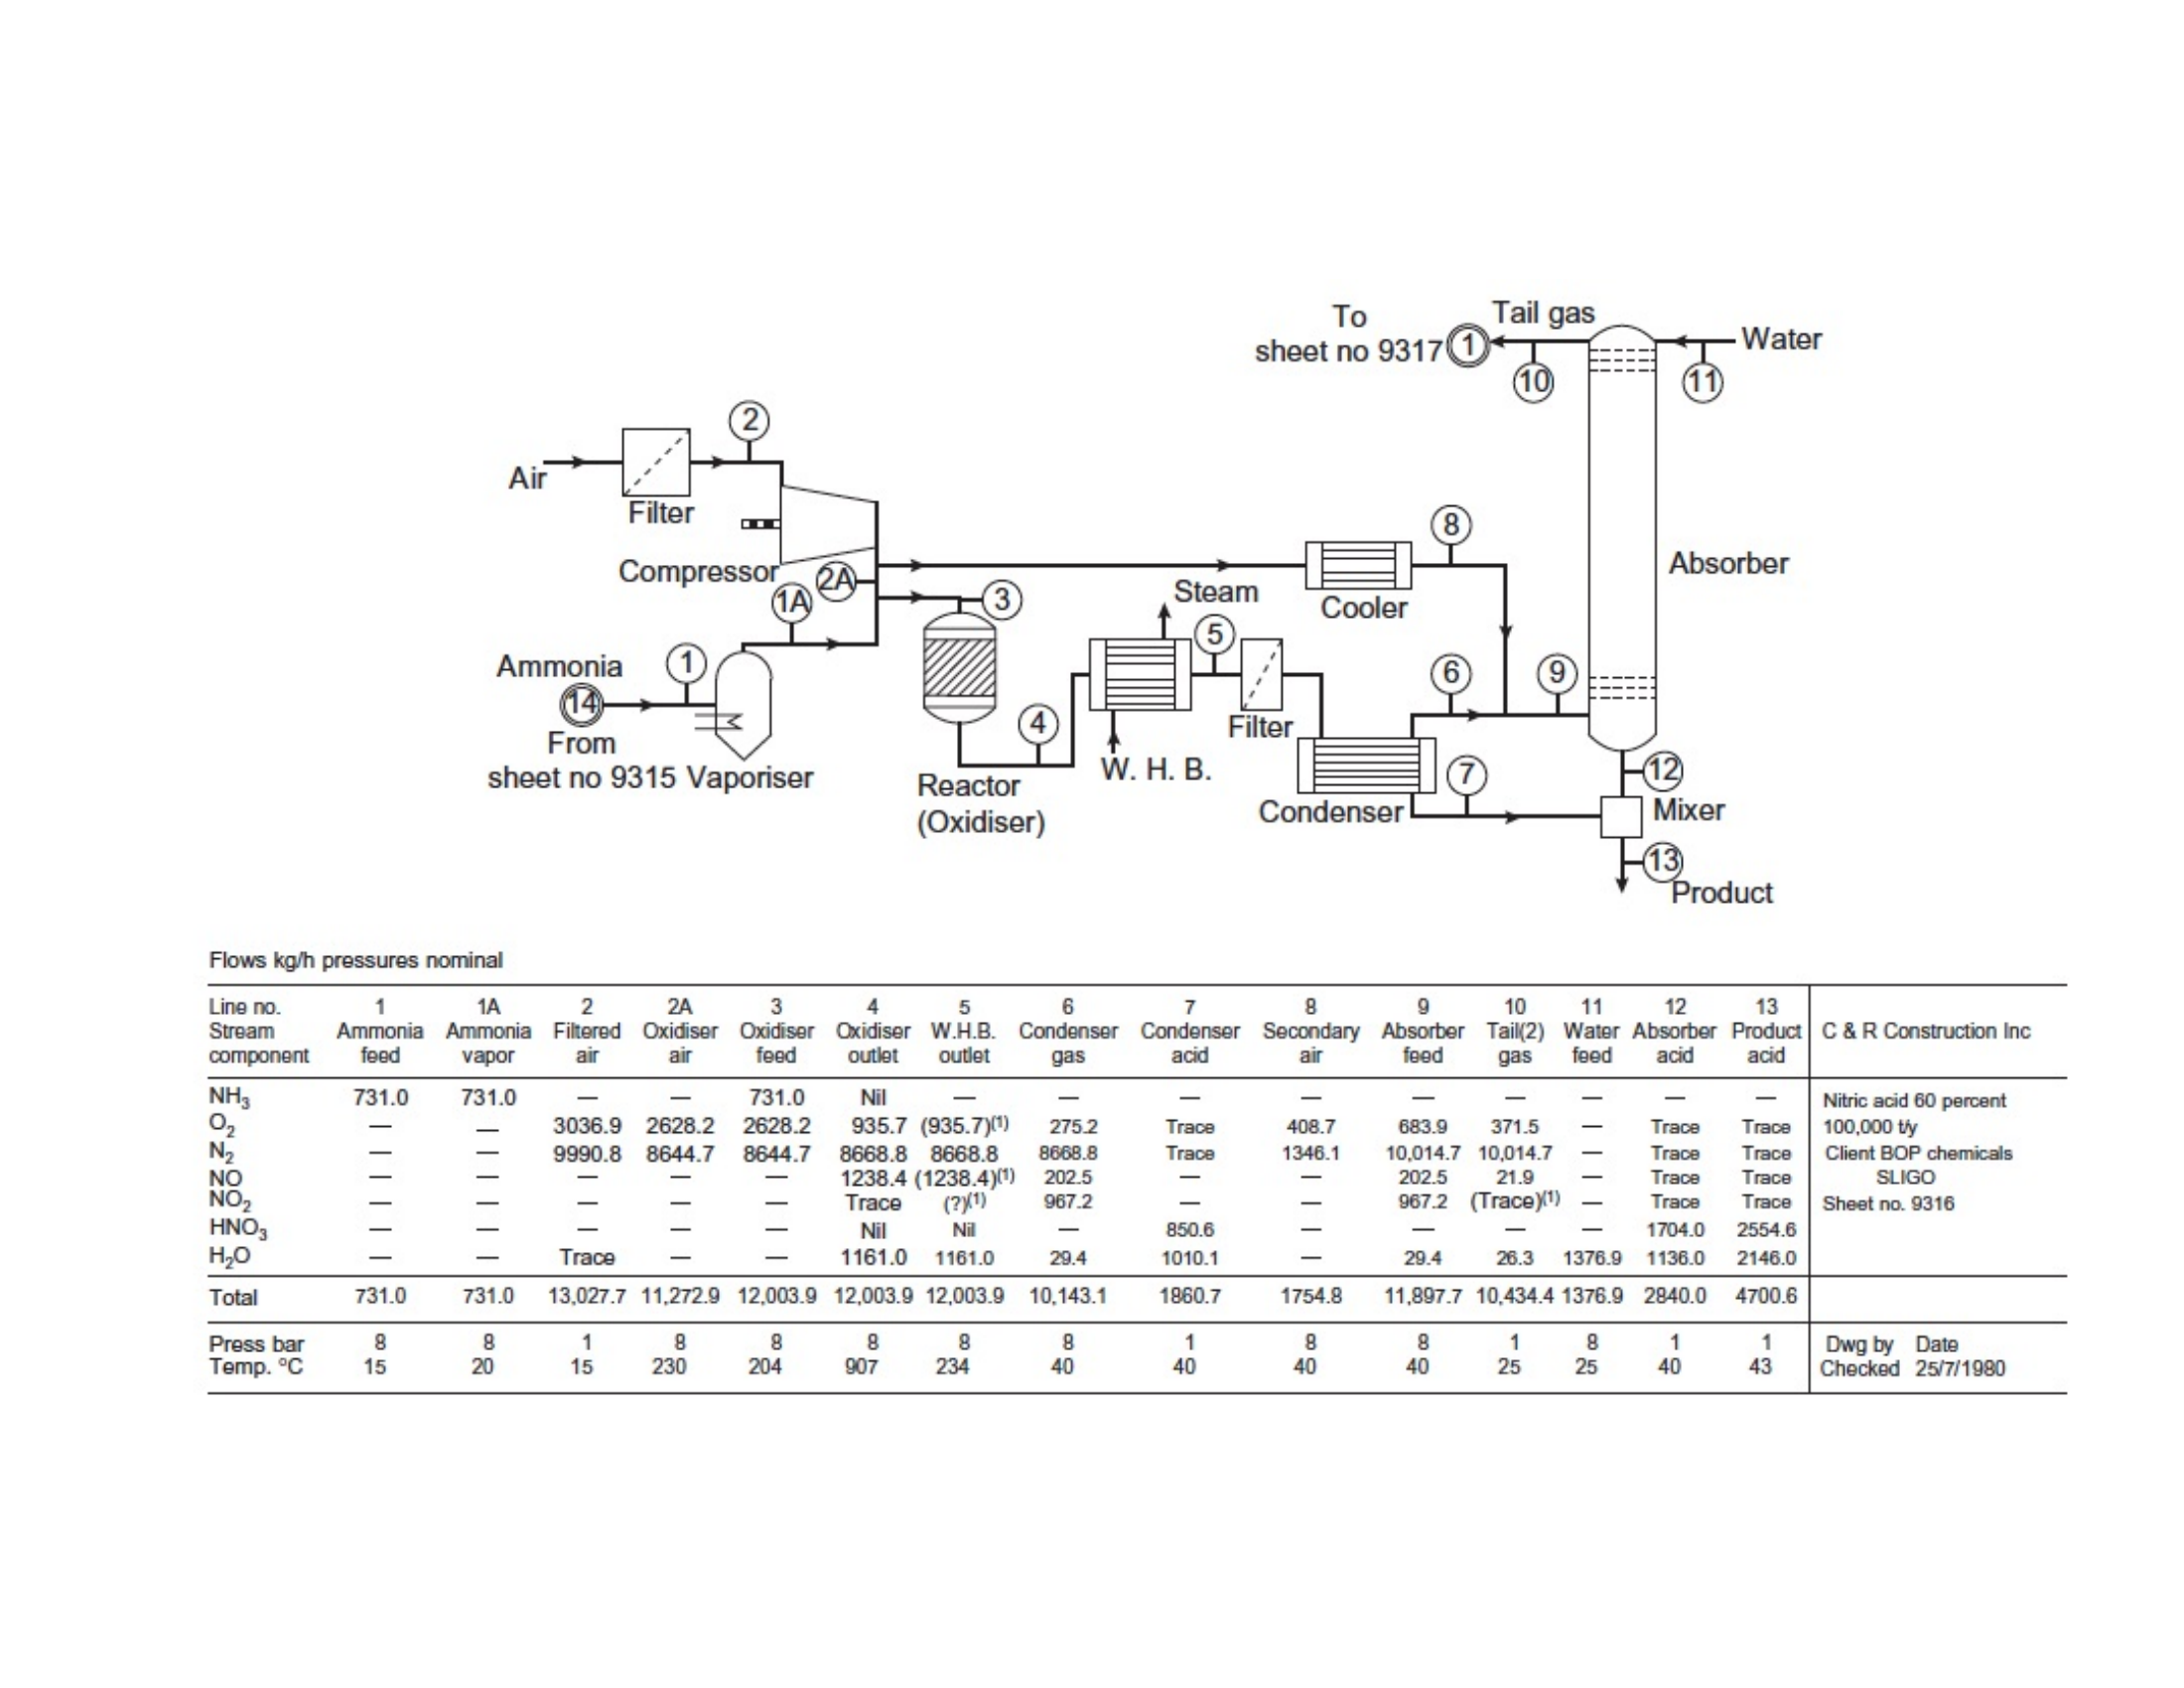

In [74]:
# open the file
file_name = 'PFD2.pdf'

# show the pdf
pdf2image.convert_from_path(file_name)[0]

Both aryn_api_key and aryn_config were provided. Using aryn_api_key
ArynPartitioner: T+   0.00: Server version 0.2024.06.28
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Server version 0.2024.06.28
ArynPartitioner: T+   0.00: Received request with aryn_call_id=c6dda14d-96a0-439d-81d7-8332acde4ce9
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Received request with aryn_call_id=c6dda14d-96a0-439d-81d7-8332acde4ce9
ArynPartitioner: T+   0.00: Waiting for scheduling
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Waiting for scheduling
ArynPartitioner: T+   0.00: Preprocessing document
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Preprocessing document
ArynPartitioner: T+   0.00: Done preprocessing document
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Done preprocessing document
ArynPartitioner: T+   1.89: completed page 1
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   1.89: completed page 1


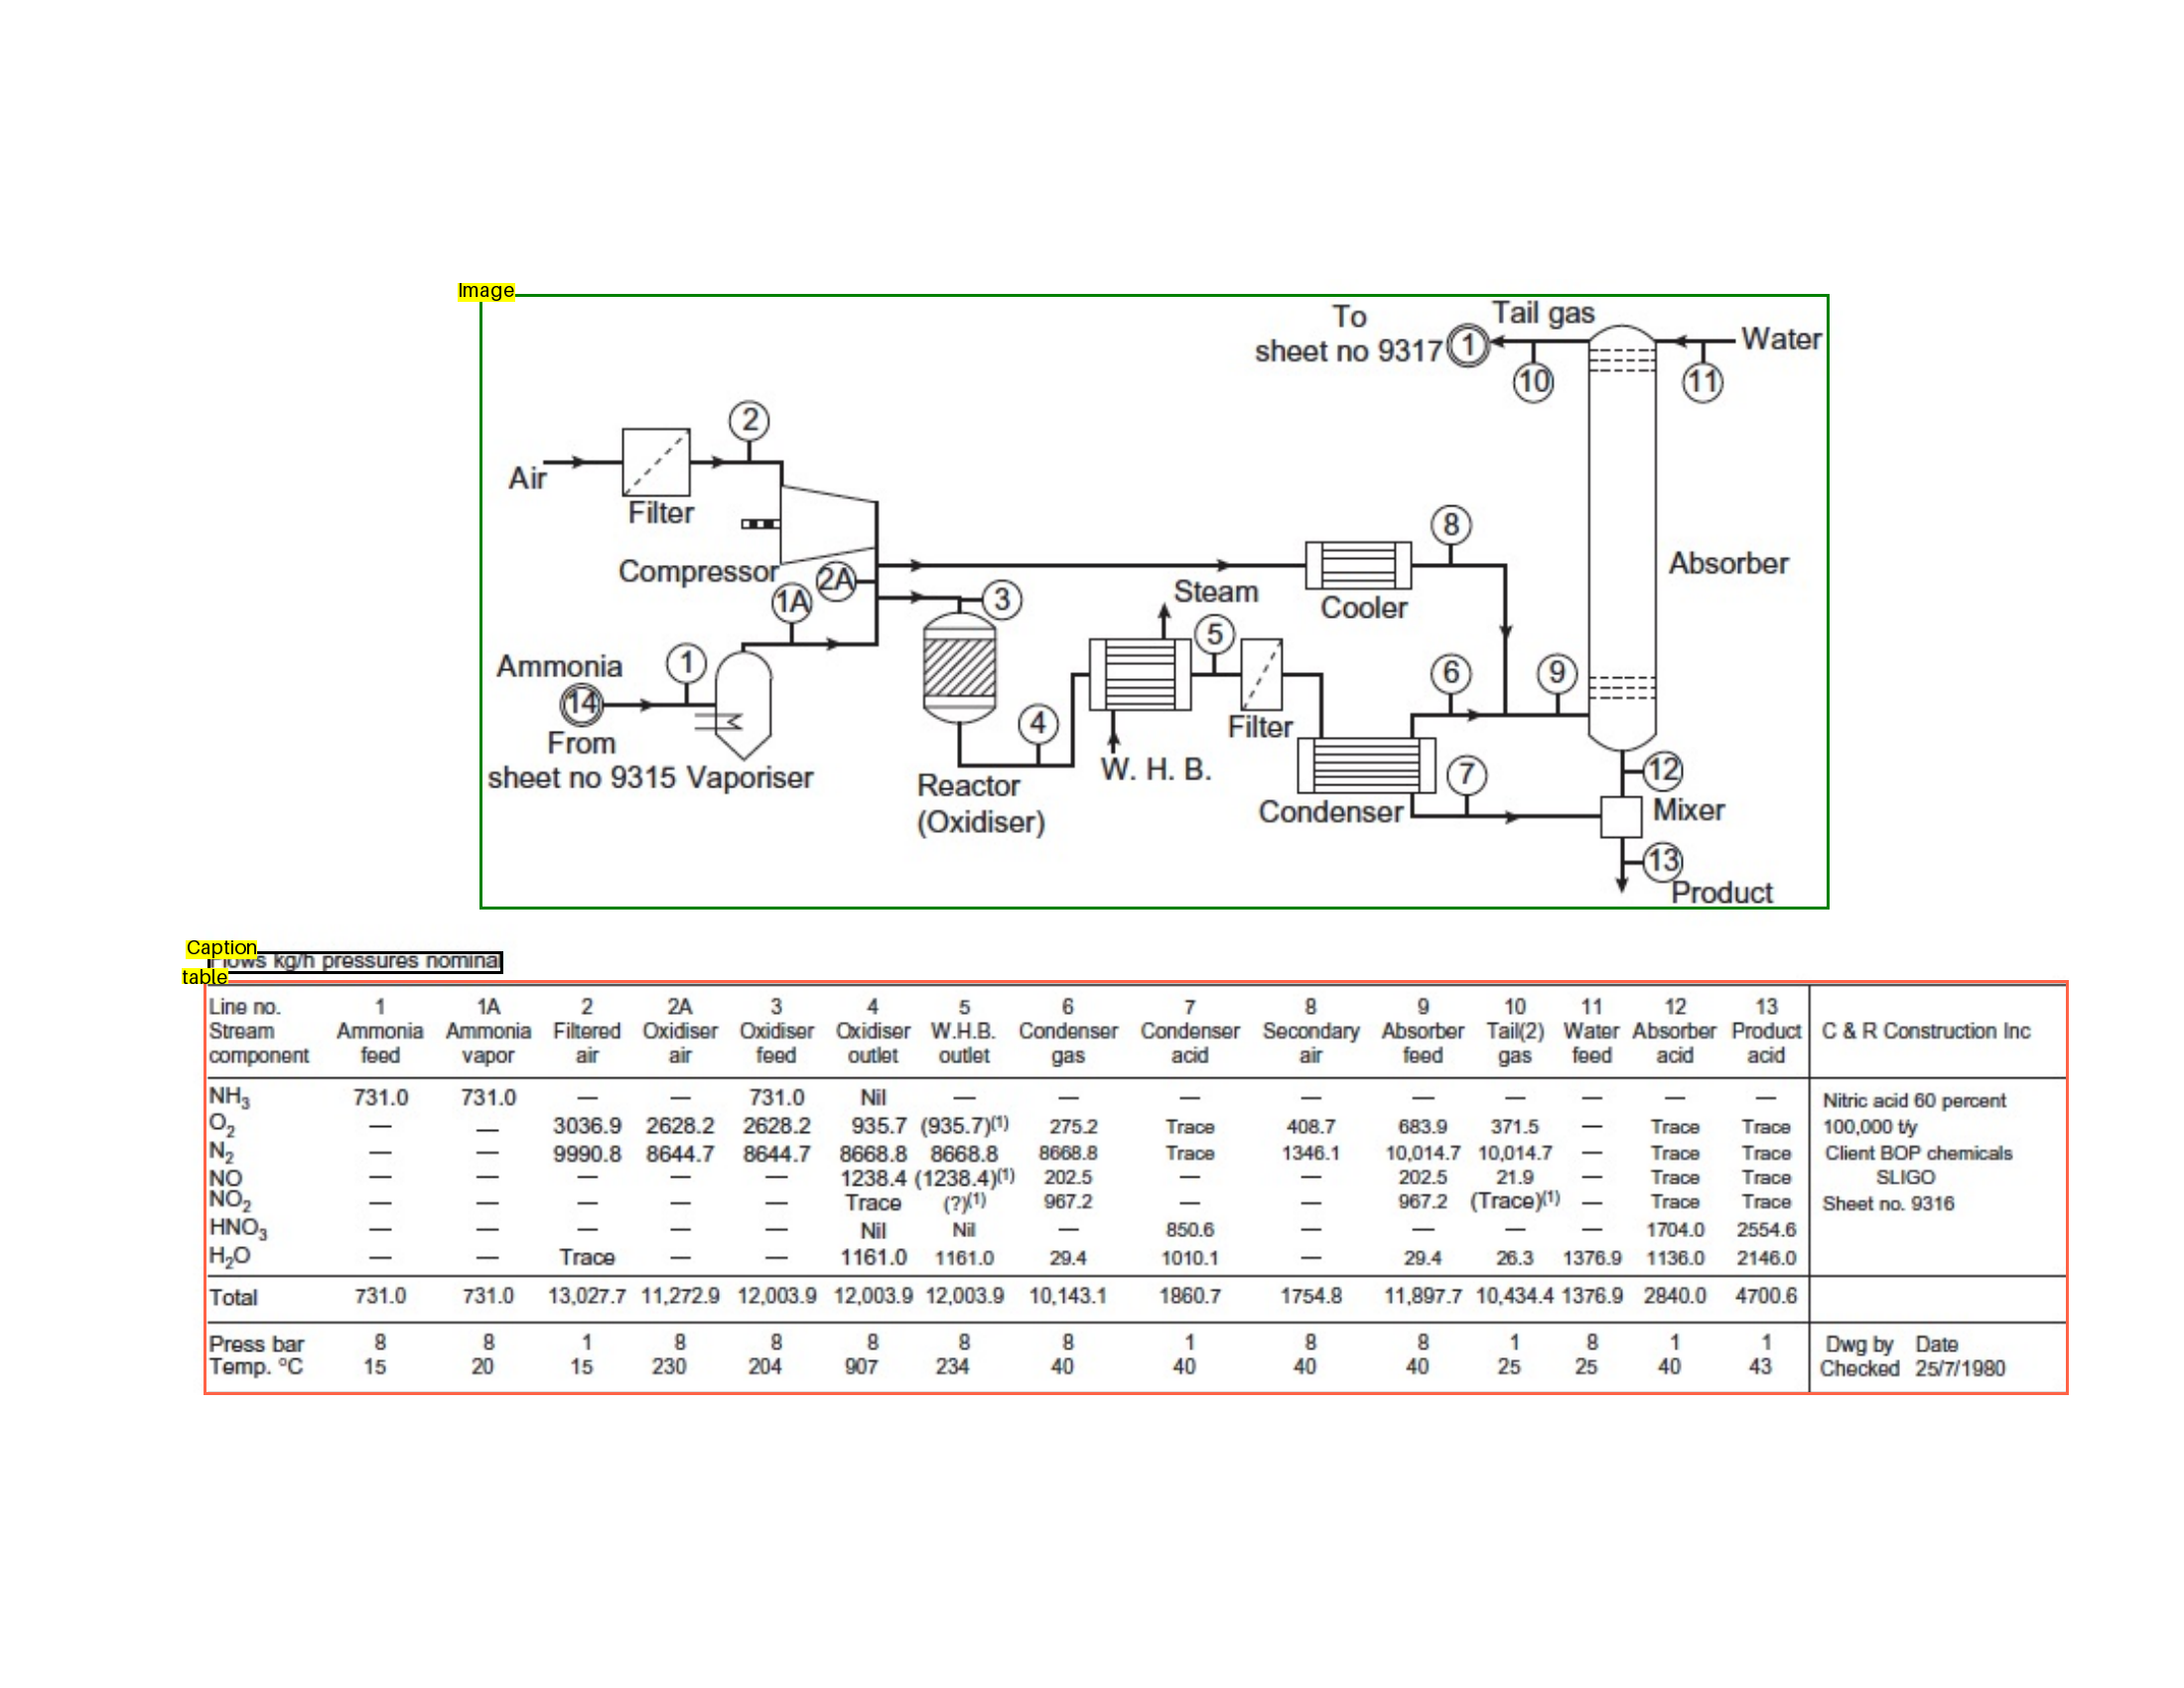

In [75]:
# Open the file.
file = open(file_name, 'rb')

## Make a call to the partitioning service to break down the file into its constituent
## components: images, tables, and captions. The documents elements are returned in a Python dict.
document_dict = partition_file(file, aryn_api_key, extract_images=True, extract_table_structure=True, use_ocr=True, threshold=0.20)

# show the pdf with bounding boxes of the elements superimposed.
draw_with_boxes(file_name, document_dict)[0]

In [76]:
## Walk over the table elements in the returned document dict and show the first one
tables = [e for e in document_dict['elements'] if e['type'] == 'table']

## Convert the table to a pandas dataframe and display it.
table_df = table_elem_to_dataframe(tables[0])
display(table_df)
print("\n")

## Walk over the image elements in the returned document dict and show the first one
images = [e for e in document_dict['elements'] if e['type'] == 'Image']
images[0]

Lina no_ Stream component Ammonia feed 1A Ammonia vapor Fikered Jir  \
0                       NH;        731.0            731.0               
1                        02                                    3036.9   
2                        Nz                                    9990.8   
3                        NO                                             
4                       NOz                                             
5                      HNO]                                             
6                       H;o                                     Trace   
7                     Total        731.0            731.0    13.027.7   
8        Press bar Temp: 'C         8 15               20          15   

  2A Oxidiser Jir         Oxidiser feed              Oxidiser outlat  \
0                                 731.0  Nil 8668.8 Trace Nil 1161.0   
1          2628.2                2628.2                                
2          8644.7                8644.7                                
3                                                                      
4                                                                      
5                                                                      
6                                                                      
7                  11,.272.9   12.003.9                                
8             230                   204                          907   

          WAB outlet Condenser ga5 Condenser acid        Secondary Jir  \
0                                                  408.7 1346.1 1754.8   
1   935.7 (935.7)01)         275.2          Traca                        
2             8668.8        8668.8          Traca                        
3  1238.4 (1238.4)0)         202.5                                       
4              (2/11         967.2                                       
5                 Ni                        850.6                        
6             1161.0          29.4         1010.1                        
7  12,003.9 12,003.9      10.143.1         1880.7                        
8                234            40             40                 8 40   

                               Absorber fead    10 Taik2) gas 11 feed  \
0  683.9 10,.014.7 202.5 967.2 29.4 11,897.7                            
1                                                       371.5           
2                                                    10,014.7           
3                                                        21.9           
4                                                   (Trace}t)           
5                                                                       
6                                                       26,.3  1376.9   
7                                             10,434.4 1376.9           
8                                         40               25      25   

                         12 Water Absorber acid 13 Product acid  \
0  Traca Traca Traca Trace 1704.0 1136.0 2840.0                   
1                                                         Traca   
2                                                         Trace   
3                                                         Trace   
4                                                         Trace   
5                                                        2554.6   
6                                                        2146.0   
7                                                        4700.6   
8                                            40              43   

                   C & R Construction Inc  
0                  Nitric acid 60 percent  
1      100,CDO ty                          
2                    Client BOP chemicals  
3                                   SLIGO  
4  Sheet no. 9316                          
5                                          
6                                          
7                                          
8  Dwg by C

{'type': 'Image',
 'bbox': [0.2196091669256037,
  0.17432988783892464,
  0.837663907137784,
  0.5383510454963235],
 'properties': {'score': 0.8979748487472534,
  'image_size': [1380, 639],
  'image_mode': 'RGB',
  'image_format': None,
  'page_number': 1},
 'text_representation': 'Water\n\nAir\n\nAbsorber\n\nsheet no 9315 Vaporiser ——\n(Oxidiser) Condenser\n',
 'binary_representation': '//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

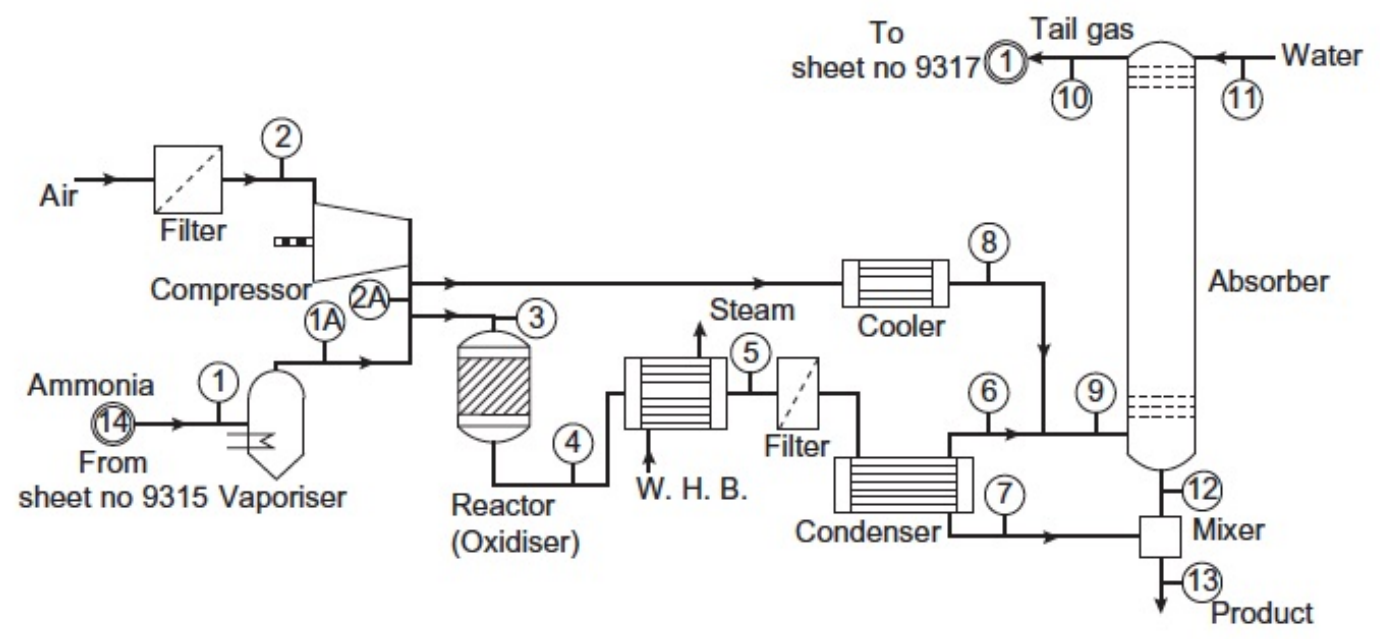

In [77]:
## Let's convert image to PIL to see it more closely.
pil_img = convert_image_element(images[0], format='PIL')
display(pil_img)

In [78]:
# Setup Pydantic models for a labeled DAG (directed acyclic graph) to form a response_format for gpt-4o
class node(BaseModel):
    label: str
    description: str

class edge(BaseModel):
    source: str
    target: str
    description: str

class diagram_DAG(BaseModel):
    nodes: list[node]
    edges: list[edge]

response_format = pydantic_to_response_format(diagram_DAG)

In [80]:
# convert image to base64 encoded JPEG for OpenAI to process it.
jpeg_img = convert_image_element(images[0], format='JPEG', b64encode=True)

# Execute a completion request to gpt-4o and print the response.
openai_client = OpenAI(api_key=openai_api_key)

response = openai_client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text",
         "text": """Transform the following PFD (process flow) diagram into a DAG and return it in JSON.
                    Ensure each node has a unique label. Ignore the labeled circles.
                 """},
        {
          "type": "image_url",
          "image_url": {"url": f"data:image/jpeg;base64,{jpeg_img}", "detail": "high"},
        },
      ],
    }
  ],
  # Ask openAI to respond back with
  response_format = response_format,
  max_tokens=1000,
)

# The response from gpt-4o will be a JSON string
DAG_json = response.choices[0].message.content
# print("Returned JSON:")
# print(DAG_json)
# print("\n")

# Load the JSON response from gpt-4o into a dict and print it
DAG_dict = json.loads(DAG_json)
print("Python DAG:")
print("Nodes:")
for n in DAG_dict['nodes']:
  print(f"  \"{n['label']}\": \"{n['description']}\"")
print("Edges:")
for e in DAG_dict['edges']:
  print(f"  \"{e['source']}\" -> \"{e['target']}\": \"{e['description']}\"")
print("\n")

Python DAG:
Nodes:
  "Node_1": "Air"
  "Node_2": "Filter"
  "Node_3": "Compressor"
  "Node_4": "Ammonia"
  "Node_5": "Reactor (Oxidiser)"
  "Node_6": "W.H.B."
  "Node_7": "Steam"
  "Node_8": "Cooler"
  "Node_9": "Filter"
  "Node_10": "Condenser"
  "Node_11": "Absorber"
  "Node_12": "Mixer"
  "Node_13": "Product"
  "Node_14": "Tail gas"
  "Node_15": "Water"
Edges:
  "Node_1" -> "Node_2": "Air goes to Filter"
  "Node_2" -> "Node_3": "Filtered air to Compressor"
  "Node_4" -> "Node_5": "Ammonia to Reactor"
  "Node_3" -> "Node_5": "Compressed air to Reactor"
  "Node_5" -> "Node_6": "Reactor output to W.H.B."
  "Node_6" -> "Node_7": "Heat exchange to Steam"
  "Node_7" -> "Node_8": "Steam to Cooler"
  "Node_8" -> "Node_9": "Cooler output to Filter"
  "Node_9" -> "Node_10": "Filter output to Condenser"
  "Node_10" -> "Node_11": "Condenser output to Absorber"
  "Node_11" -> "Node_12": "Output to Mixer"
  "Node_12" -> "Node_13": "Mixing to Product"
  "Node_13" -> "Node_14": "Output to Tail gas"

In [81]:
# This function combines all of the above mentioned steps

def convert_pfd_to_dag(pfd_fn: str, openai_client: OpenAI) -> dict:

  # show the first page of the PDF
  # display(pdf2image.convert_from_path(pfd_fn)[0])

  # Open the file.
  pfd_file = open(pfd_fn, 'rb')

  ## Make a call to the partitioning service to break down the filex into their constituent
  ## components: images, tables, and captions.
  pfd_dict = partition_file(pfd_file, aryn_api_key, extract_images=True, extract_table_structure=True, use_ocr=True, threshold=0.20)

  ## Walk over the image elements in the returned document dict and show the first one
  pfd_images = [e for e in pfd_dict['elements'] if e['type'] == 'Image']

  print("Converting this PFD diagram: ")
  ## Let's convert image to PIL to see it more closely.
  pfd_pil_img = convert_image_element(pfd_images[0], format='PIL')
  display(pfd_pil_img)

  # convert image to base64 encoded JPEG for gpt-4o-mini to process it.
  pfd_jpeg = convert_image_element(pfd_images[0], format='JPEG', b64encode=True)

  print("Calling gpt-4o: ")
  response = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text",
           "text": """Transform the following PFD (process flow) diagram into a DAG and return it in JSON.
                      Ensure each node has a unique label. """},
          {"type": "image_url",
           "image_url": {"url": f"data:image/jpeg;base64,{pfd_jpeg}", "detail": "high"},},
        ],
      }
    ],

    # Ask openAI to respond back with
    response_format = response_format,
    max_tokens=5000,
  )

  # The response from gpt-4o will be a JSON string
  pfd_json = response.choices[0].message.content
  # print("Returned JSON:")
  # print(pfd_json)
  # print("\n")

  # Load the JSON response from gpt-4o into a dict and print it
  pfd_DAG = json.loads(pfd_json)
  print("Python DAG:")
  print("Nodes:")
  for n in pfd_DAG['nodes']:
    print(f"  \"{n['label']}\": \"{n['description']}\"")
  print("Edges:")
  for e in pfd_DAG['edges']:
    print(f"  \"{e['source']}\" -> \"{e['target']}\": \"{e['description']}\"")
  print("\n")

  return pfd_DAG

Both aryn_api_key and aryn_config were provided. Using aryn_api_key
ArynPartitioner: T+   0.00: Server version 0.2024.06.28
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Server version 0.2024.06.28
ArynPartitioner: T+   0.00: Received request with aryn_call_id=ba56826b-e9e6-4bf7-af21-754a67ca4031
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Received request with aryn_call_id=ba56826b-e9e6-4bf7-af21-754a67ca4031
ArynPartitioner: T+   0.00: Waiting for scheduling
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Waiting for scheduling
ArynPartitioner: T+   0.00: Preprocessing document
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Preprocessing document
ArynPartitioner: T+   0.00: Done preprocessing document
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Done preprocessing document
ArynPartitioner: T+   0.57: completed page 1
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.57: completed page 1


Converting this PFD diagram: 


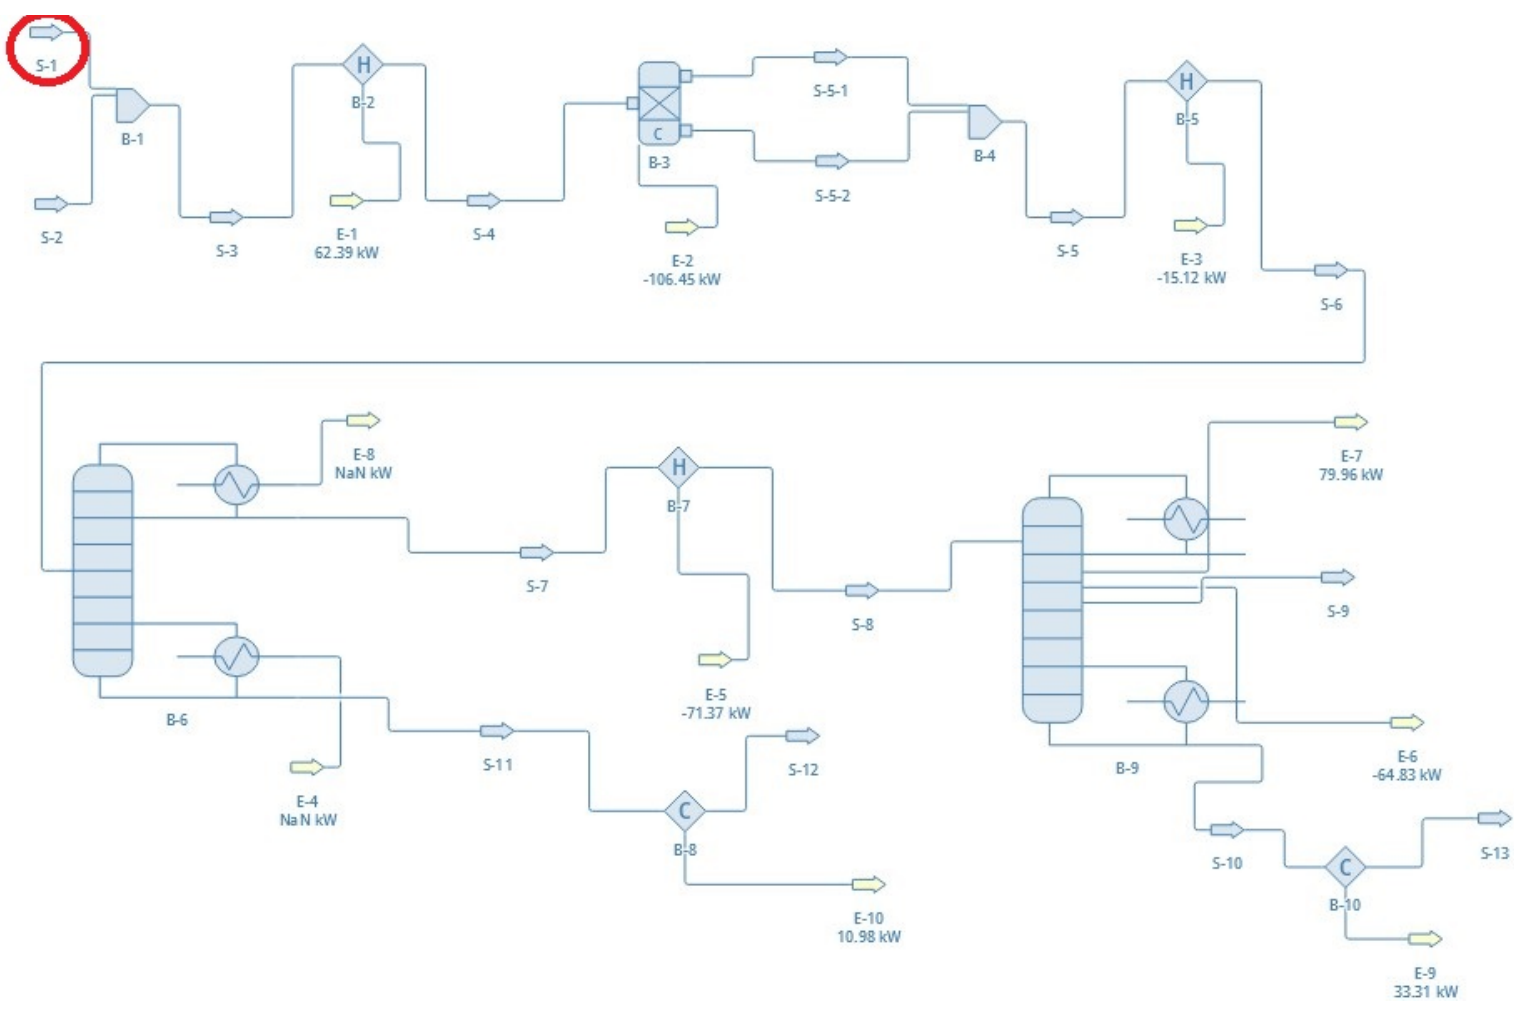

Calling gpt-4o: 


Both aryn_api_key and aryn_config were provided. Using aryn_api_key


Python DAG:
Nodes:
  "S-1": "Start node"
  "B-1": "Block 1"
  "B-2": "Block 2"
  "E-1": "Energy Exchange 1"
  "S-2": "Stream 2"
  "S-3": "Stream 3"
  "S-4": "Stream 4"
  "C": "Compressor"
  "B-3": "Block 3"
  "E-2": "Energy Exchange 2"
  "S-5": "Stream 5"
  "S-5-1": "Stream 5-1"
  "B-4": "Block 4"
  "S-5-2": "Stream 5-2"
  "S-6": "Stream 6"
  "B-5": "Block 5"
  "E-3": "Energy Exchange 3"
  "S-7": "Stream 7"
  "H": "Heater"
  "B-7": "Block 7"
  "S-8": "Stream 8"
  "B-6": "Block 6"
  "E-8": "Energy Exchange 8"
  "S-11": "Stream 11"
  "E-4": "Energy Exchange 4"
  "C-2": "Compressor 2"
  "B-8": "Block 8"
  "E-10": "Energy Exchange 10"
  "S-10": "Stream 10"
  "E-7": "Energy Exchange 7"
  "S-9": "Stream 9"
  "B-9": "Block 9"
  "E-6": "Energy Exchange 6"
  "S-12": "Stream 12"
  "S-13": "Stream 13"
  "B-10": "Block 10"
  "C-3": "Compressor 3"
Edges:
  "S-1" -> "B-1": "Input to Block 1"
  "B-1" -> "B-2": "Flow from Block 1 to Block 2"
  "B-2" -> "E-1": "Output from Block 2 to Energy Exchange 1"

ArynPartitioner: T+   0.00: Server version 0.2024.06.28
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Server version 0.2024.06.28
ArynPartitioner: T+   0.00: Received request with aryn_call_id=ab8d0bde-c64f-48ab-b9df-8f8ba9e3836e
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Received request with aryn_call_id=ab8d0bde-c64f-48ab-b9df-8f8ba9e3836e
ArynPartitioner: T+   0.00: Waiting for scheduling
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Waiting for scheduling
ArynPartitioner: T+   0.00: Preprocessing document
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Preprocessing document
ArynPartitioner: T+   0.00: Done preprocessing document
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.00: Done preprocessing document
ArynPartitioner: T+   0.47: completed page 1
INFO:aryn_sdk.partition.partition:ArynPartitioner: T+   0.47: completed page 1


Converting this PFD diagram: 


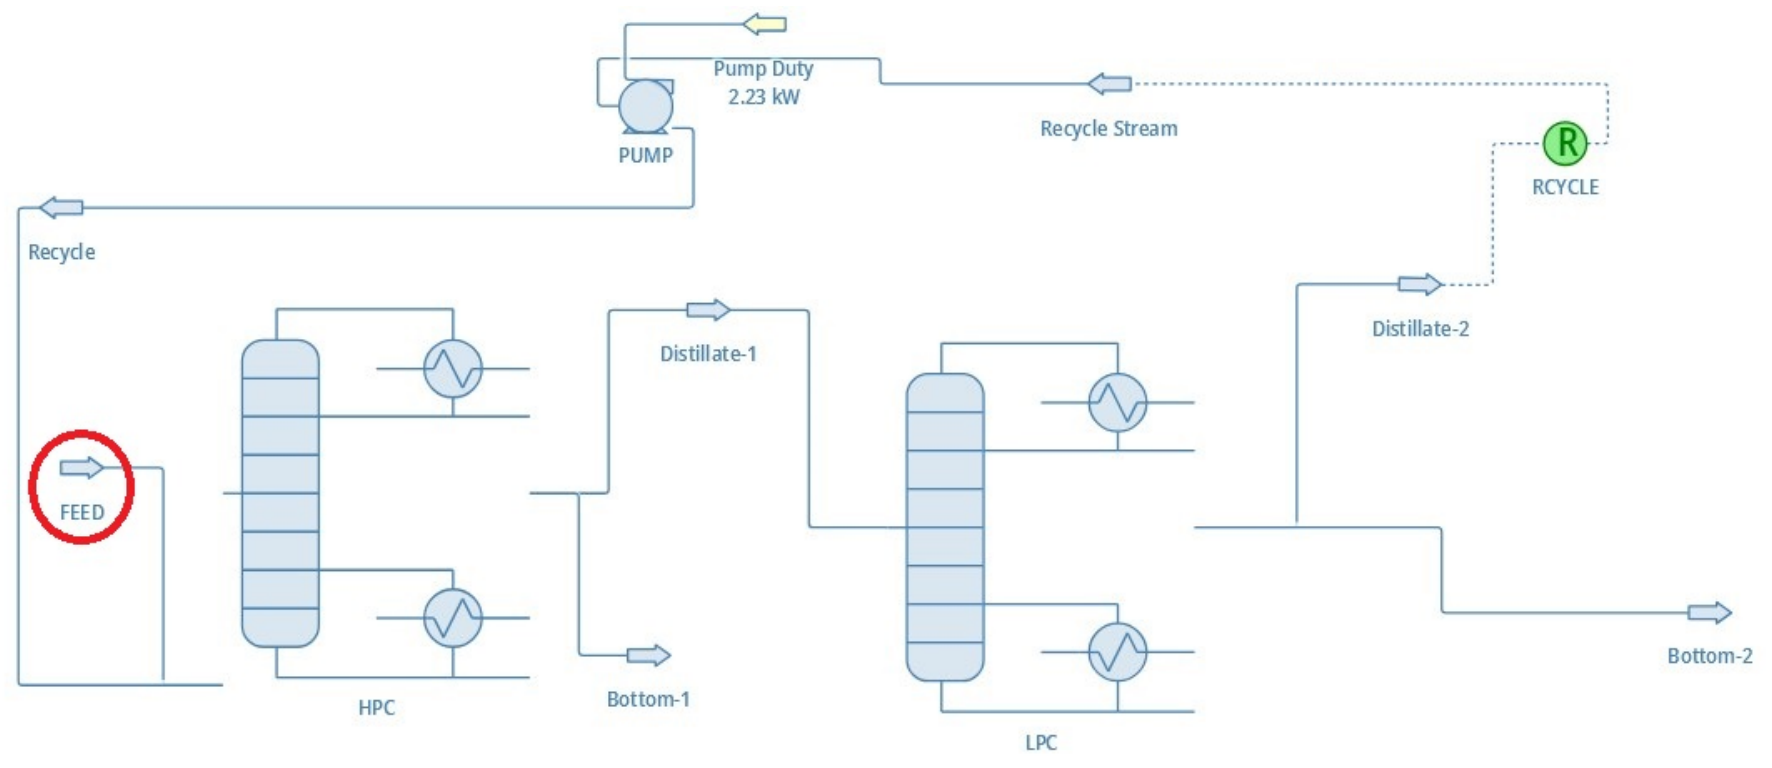

Calling gpt-4o: 
Python DAG:
Nodes:
  "Feed": "Initial feed input to the process."
  "HPC": "High-pressure column processing."
  "LPC": "Low-pressure column processing."
  "Distillate-1": "First product output from HPC."
  "Distillate-2": "Second product output from LPC."
  "Bottom-1": "Bottom product from HPC."
  "Bottom-2": "Bottom product from LPC."
  "Pump": "Pump to manage recycle stream."
  "Recycle": "Recycle stream."
Edges:
  "Feed" -> "HPC": "Feed goes to High-pressure column."
  "HPC" -> "Distillate-1": "Distillate-1 produced from HPC."
  "HPC" -> "Bottom-1": "Bottom-1 produced from HPC."
  "HPC" -> "Pump": "Bottom-1 is pumped for recycling."
  "Pump" -> "Recycle": "Pump sends stream to recycle."
  "Recycle" -> "LPC": "Recycle stream feeds into LPC."
  "LPC" -> "Distillate-2": "Distillate-2 produced from LPC."
  "LPC" -> "Bottom-2": "Bottom-2 produced from LPC."




{'nodes': [{'label': 'Feed',
   'description': 'Initial feed input to the process.'},
  {'label': 'HPC', 'description': 'High-pressure column processing.'},
  {'label': 'LPC', 'description': 'Low-pressure column processing.'},
  {'label': 'Distillate-1', 'description': 'First product output from HPC.'},
  {'label': 'Distillate-2', 'description': 'Second product output from LPC.'},
  {'label': 'Bottom-1', 'description': 'Bottom product from HPC.'},
  {'label': 'Bottom-2', 'description': 'Bottom product from LPC.'},
  {'label': 'Pump', 'description': 'Pump to manage recycle stream.'},
  {'label': 'Recycle', 'description': 'Recycle stream.'}],
 'edges': [{'source': 'Feed',
   'target': 'HPC',
   'description': 'Feed goes to High-pressure column.'},
  {'source': 'HPC',
   'target': 'Distillate-1',
   'description': 'Distillate-1 produced from HPC.'},
  {'source': 'HPC',
   'target': 'Bottom-1',
   'description': 'Bottom-1 produced from HPC.'},
  {'source': 'HPC',
   'target': 'Pump',
   'd

In [82]:
convert_pfd_to_dag('PFD_2017.pdf', openai_client)
convert_pfd_to_dag('PFD_2018.pdf', openai_client)